<a href="https://colab.research.google.com/github/DanielHolzwart/spam-filter-with-distilbert-and-gpt2/blob/main/Spam_filter_with_Distilbert_and_GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this workbook we are going to train the two large language model Distilbert and GPT2 to classifying spam and non spam SMS. An obvious choice for this are BERt or Distilbert having a classification token which, after adding a classification head the to uncased mode, whether SMS are positive (spam) or negative (ham). GTP2 on the other hand, seems to be less suitable for such a case, as it is a decoder text generation transformer. Nevertheless, we are still trying to check whether we can build a GPT2 classifier.

In the first section we will train Distilbert as a classfier. Thereafter, we are slightly going to modify the training set in such a way that GPT2 can learn to decide whether an SMS is spam or not. The idea is the following: consider an example SMS

*'You just received 100 Bitcoins to your wallet'*     

with label *'Spam'*. We adjust the training data into

*'You just received 100 Bitcoins to your wallet --- This SMS is: Spam'*.

# Load libraries and SMS dataset

In [ ]:
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch

The SMS Spam Collection v.1 is a public set of SMS labeled messages that have been collected for mobile phone spam research. It has one collection composed by 5,574 English, real and non-enconded messages, tagged according being legitimate (ham) or spam.

In [ ]:
%%capture
%pip install datasets

In [ ]:
from datasets import load_dataset
dataset = load_dataset("ucirvine/sms_spam")
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/359k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 5574
    })
})


In [ ]:
pd_dataset = pd.DataFrame(dataset['train'], columns = ['sms','label']) # store the data in a pandas dataframe
pd_dataset.head(4)

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0


Notice that the labels are already tokenized.

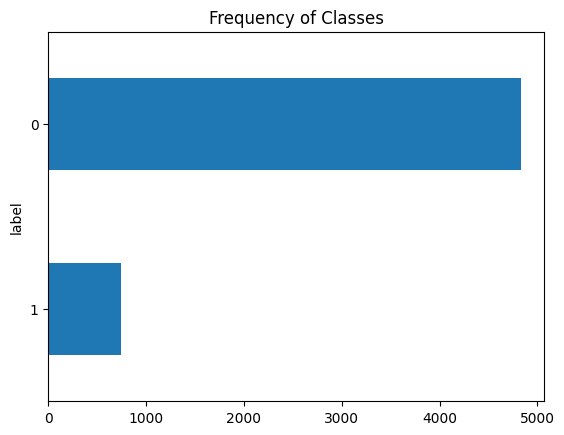

In [ ]:
pd_dataset["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

We also need to check how long our SMS are as the models have fixed input size. For example, Distilbet has input size of 512 tokens. Usually SMS are not that long so that should not be a problem.

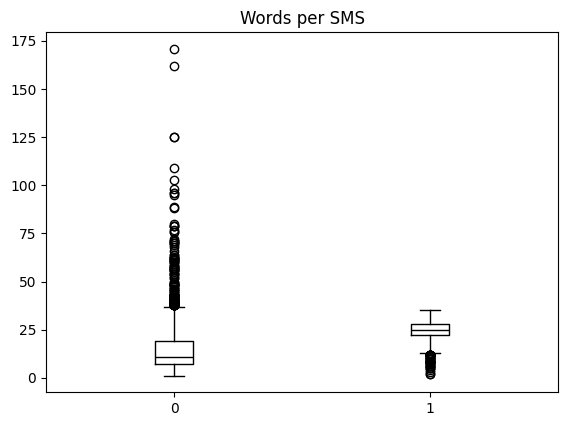



Maximum SMS length is: 171


In [ ]:
pd_dataset["Words per SMS"] = pd_dataset["sms"].str.split().apply(len) # split words into list and apply len function
pd_dataset.boxplot("Words per SMS", by="label", grid=False, showfliers=True, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()
print('\n')
print(f'Maximum SMS length is: {np.max(pd_dataset["Words per SMS"])}')

## 1.0 Naive Bayes classifier

To have a baseline for classifying spam emails, it make sense to look at a simple Naive Bayes classifier. We will create a simple one with straight-forward tokenization via Countvectorziers (bag of words model)

In [ ]:
# load the nesseccary libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [ ]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(pd_dataset["sms"], pd_dataset["label"], test_size=0.2, random_state=42, shuffle = True, stratify = pd_dataset["label"]) #stratify ensurer that the split of label is the same

In [ ]:
sum(y_train)/len(X_train) - sum(y_test)/len(X_test) # roughly the same amount of labels per split

0.0004785001764959773

In [ ]:
# Now we fit our Naive Bayes classifiert
# convert text to feature vectors using CountVectorizer
vectorizer = CountVectorizer()
X_train_token = vectorizer.fit_transform(X_train)
X_test_token = vectorizer.transform(X_test)

# train a Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train_token, y_train)

# make predictions on the test set
y_pred = model.predict(X_test_token)

# evaluate the model. Precission and recall is the correct evluation metric since the dataset is highly imbalanced
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Martrix:\n", confusion_matrix(y_test, y_pred))
print("\nf1_score:\n", f1_score(y_test, y_pred))

Accuracy: 0.9847533632286996

Confusion Martrix:
 [[963   3]
 [ 14 135]]

f1_score:
 0.9407665505226481


The f1 score will be our value to estimate the performace of the models.

Let us investigate where the classifier went wrong. There are 3 cases where the classifier wrongly marked non-spam as spam. The values in the brackets behind the messages are the probabilities of our classifier.

In [ ]:
model.predict_proba(X_test_token)[(y_pred == 1) & (y_test.values == 0)]

array([[0.45500046, 0.54499954],
       [0.01657267, 0.98342733],
       [0.14506796, 0.85493204]])

In [ ]:
fp_sms = X_test[(y_pred == 1) & (y_test.values == 0)]
fp_sms_proba = model.predict_proba(X_test_token)[(y_pred == 1) & (y_test.values == 0)]
print('\nFalse positive SMS:\n')
for i, sms in enumerate(fp_sms):
    print("%2d) %-s (%.2f%%)" % (i+1, sms.strip(), fp_sms_proba[i, 1] * 100)) # use the strip function as the sms contain \n


False positive SMS:

 1) Can u get pic msgs to your phone? (54.50%)
 2) We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us (98.34%)
 3) Nokia phone is lovly.. (85.49%)


Similarly, we can check the false negative cases.

In [ ]:
fn_sms = X_test[(y_pred == 0) & (y_test.values == 1)]
fn_sms_proba = model.predict_proba(X_test_token)[(y_pred == 0) & (y_test.values == 1)]
print('\nFalse negative SMS:\n')
for i, sms in enumerate(fn_sms):
    print("%2d) %-s (%.2f%%)" % (i+1, sms.strip(), fn_sms_proba[i, 0] * 100)) # use the strip function as the sms contain an \n


False negative SMS:

 1) Ever thought about living a good life with a perfect partner? Just txt back NAME and AGE to join the mobile community. (100p/SMS) (87.78%)
 2) Hi ya babe x u 4goten bout me?' scammers getting smart..Though this is a regular vodafone no, if you respond you get further prem rate msg/subscription. Other nos used also. Beware! (100.00%)
 3) ROMCAPspam Everyone around should be responding well to your presence since you are so warm and outgoing. You are bringing in a real breath of sunshine. (100.00%)
 4) Sorry I missed your call let's talk when you have the time. I'm on 07090201529 (100.00%)
 5) More people are dogging in your area now. Call 09090204448 and join like minded guys. Why not arrange 1 yourself. There's 1 this evening. A£1.50 minAPN LS278BB (99.79%)
 6) Talk sexy!! Make new friends or fall in love in the worlds most discreet text dating service. Just text VIP to 83110 and see who you could meet. (82.95%)
 7) Can U get 2 phone NOW? I wanna chat 2 set up

Interestingly, our classifier is fairly confident that some sms are not spam even though they obviously are. Let's see whether our transformer models can do better in the next chapter.

We can also test this classifier on some sample sentences.

In [ ]:
spam_sms_list = [
    "Congrats! You've won a $1,000 Walmart Gift Card! Click here to claim: [fake link] Hurry, offer expires today!",
    "ALERT: Unusual activity detected on your account. Please verify immediately at [fake bank link] to avoid suspension.",
    "Your package could not be delivered. Schedule a redelivery here: [fake link].",
    "You are the lucky winner of our $10,000 sweepstakes! Reply YES to claim now or visit [fake link].",
    "Microsoft: Critical issue detected on your computer. Call now: 1-800-FAKE-NUM to resolve.",
    "We have reviewed your resume. Earn $3,000/week working from home! Apply now at [fake link].",
    "Your subscription to Netflix will expire today. Update payment details here to avoid service interruption: [fake link].",
    "Congratulations! Your loan of $5,000 is pre-approved. Low interest rates! Apply now: [fake link]."
]

In [ ]:
print(model.predict(vectorizer.transform(spam_sms_list)))

[1 1 0 1 1 1 1 1]


In [ ]:
non_spam_sms_list = [
    "Hi! Just checking in to see if you're free for dinner tomorrow.",
    "Your Amazon order has been shipped and will arrive on Tuesday. Track your package here: [legit tracking link].",
    "Your dentist appointment is scheduled for 3:00 PM on Friday.",
    "Hey, can you send me the notes from today’s meeting? Thanks!",
    "Your monthly phone bill of $45.00 is due on the 15th. Pay online at [legit payment link].",
    "Happy Birthday! Hope you have an amazing day filled with love and laughter.",
    "We’re meeting at 7:00 PM at the café. Let me know if you’re running late.",
    "Thanks for your purchase! Your receipt is attached. Have a great day!"
]

In [ ]:
print(model.predict(vectorizer.transform(non_spam_sms_list)))

[0 1 1 0 0 0 0 0]


We will use those samples for our transformer models as well.

# 2. Distilbert

After having established a classical classifier (which yield suprisingly good results), we will take our attention to Distilbert to tackle the same problem. We download the model from the HuggingFace API with a classification head on top of it.

## 2.1 Download Distilbert

In [ ]:
# load Distilbert model from Huggingface
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer_bert = AutoTokenizer.from_pretrained("distilbert-base-uncased")
num_labels = 2 # two labels for spam/ham classification
model_bert = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Put Model on GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert = model_bert.to(device)

Let's take an example SMS and tokenize it and evaluate the uncased model on it.

In [ ]:
sample = pd_dataset['sms'][0]
print(sample)

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



In [ ]:
sample_ids = tokenizer_bert(sample, return_tensors = 'pt').to(device)
sample_output = model_bert(**sample_ids) #output shape is (batch_size, num_labels)

In [ ]:
sample_output.logits

tensor([[ 0.0389, -0.0324]], device='cuda:0', grad_fn=<AddmmBackward0>)

In general, the base model BERT (or DisitlBert) without the classification head has a [CLS] token, which we can access. This allows us to visualize the model's prediction via UMAP in the preceding section. Notice that the base part of Distilbert, without the classification head, has already been finetuned. Therefore, the [CLS] token might has meaningful output which we will investigate now. The model's output can be converted back to the token form which reveals the position of the classifier token.

In [ ]:
sample_tokens = tokenizer_bert.convert_ids_to_tokens(sample_ids.input_ids.squeeze(0)) # tokenized form of our sample text
print(sample_tokens)
print(tokenizer_bert.convert_tokens_to_string(sample_tokens))

['[CLS]', 'go', 'until', 'ju', '##rong', 'point', ',', 'crazy', '.', '.', 'available', 'only', 'in', 'bug', '##is', 'n', 'great', 'world', 'la', 'e', 'buffet', '.', '.', '.', 'ci', '##ne', 'there', 'got', 'amore', 'wat', '.', '.', '.', '[SEP]']
[CLS] go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat... [SEP]


We use the [CLS] token to determine whether an SMS is spam or ham. As we saw in the previous step, it is the first token in tokenization step. We can access this token via the last_hidden_state functionality of the output.

In [ ]:
hidden_states = model_bert(**sample_ids, output_hidden_states=True).hidden_states
last_hidden_state = hidden_states[-1]

In [ ]:
last_hidden_state.shape # output size (batch_size, tokens, embedding_dim)

torch.Size([1, 34, 768])

The next step is to tokenize the whole dataset. We will pad the dataset into full length by setting batch_size = None. This extends our dataset by two additional columns tokenizer.model_input_names, i.e., attention mask and input_ids.

## 2.2. Tokenize dataset

In [ ]:
def tokenize(batch, tokenizer = tokenizer_bert):
    return tokenizer(batch["sms"], padding='max_length', truncation=True)

We are going to use the split of X_train and X_test as above and store them in a Dataset

In [ ]:
from datasets import Dataset, DatasetDict
df_train = X_train.to_frame(name = 'sms').copy()
df_train['label'] = y_train
ds_train = Dataset.from_pandas(df_train) #create train dataset

df_test = X_test.to_frame(name = 'sms').copy()
df_test['label'] = y_test
ds_test = Dataset.from_pandas(df_test) #create test dataset

ds = DatasetDict({'train' : ds_train, 'test' : ds_test})

In [ ]:
dataset_encoded = ds.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/4459 [00:00<?, ? examples/s]

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

From this operation we see the padding function in action as the input_ids of our first example has been extended.

In [ ]:
pd.DataFrame(dataset_encoded['test']).iloc[0]

,0
sms,No message..no responce..what happend?\n
label,0
__index_level_0__,3625
input_ids,"[101, 2053, 4471, 1012, 1012, 2053, 24501, 260..."
attention_mask,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
len(dataset_encoded['train'][0]['input_ids'])

512

Having tokenized the dataset, we need to extract [CLS] token of the last hidden state. For this, similar to the tokenize_bert() function, we define a new function last_hidden_state() taking a batch as an input and output the last hidden state. Using map once we again we apply the function to the whole dataset.

In [ ]:
def get_hidden_states(batch, model = model_bert, tokenizer = tokenizer_bert):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs, output_hidden_states=True).hidden_states[-1] # hidden_states[-1] is the last hidden state before the head classifier in the fully connected network
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()} # map function does not allow tensors on CPU

In [ ]:
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['sms', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 4459
    })
    test: Dataset({
        features: ['sms', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1115
    })
})

In [ ]:
dataset_encoded.set_format('torch', columns = ['input_ids', 'attention_mask', 'label']) # set tensors as input for our model

In [ ]:
dataset_hidden = dataset_encoded.map(get_hidden_states, batched = True, batch_size = 32) # setting batch_size to 32 as otherwise GPU runs out of memory

Map:   0%|          | 0/4459 [00:00<?, ? examples/s]

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

Checking the column names we can see that another column to the dataset has been added.

In [ ]:
dataset_hidden.column_names

{'train': ['sms',
  'label',
  '__index_level_0__',
  'input_ids',
  'attention_mask',
  'hidden_state'],
 'test': ['sms',
  'label',
  '__index_level_0__',
  'input_ids',
  'attention_mask',
  'hidden_state']}

## 2.3 Tokenization example

In the previous section we have downloaded our Distilbert model, tokenized the whole dataset and extracted hidden states of the classifier token, which we will feed into the head of our model to make predictions. The purpose of this section is to take a step back and see how the map functions actually acts on the our datasets by creating a sample dataset.

In [ ]:
from datasets import Dataset, DatasetDict
sample_dict = dict()
sample_dict.update({"sms": ["This is a spam message","This one not"],"label" : [1,0]}) # create sample dictionary
print(f'Dataframe output: \n {pd.DataFrame.from_dict(sample_dict)}') # dataframe output of sample
sample_dataset = Dataset.from_dict(sample_dict) # create Dataset to apply the map function on
sample_datadict = DatasetDict({"examples": sample_dataset})
tmp = sample_datadict.map(tokenize, batched = True)
print(f'Dataframe output with tokenize applied: \n {pd.DataFrame(tmp)}') # print

Dataframe output: 
                       sms  label
0  This is a spam message      1
1            This one not      0


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Dataframe output with tokenize applied: 
                                             examples
0  {'sms': 'This is a spam message', 'label': 1, ...
1  {'sms': 'This one not', 'label': 0, 'input_ids...


The next step is to get the lasst hidden states.

In [ ]:
tmp.set_format('torch', columns = ['input_ids','label', 'attention_mask'])
tmp_hidden = tmp.map(get_hidden_states, batched = True)

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

In [ ]:
print(f'Dataframe output with tokenize applied: \n {pd.DataFrame(tmp_hidden)}')

Dataframe output with tokenize applied: 
                                             examples
0  {'label': tensor(1), 'input_ids': [tensor(101)...
1  {'label': tensor(0), 'input_ids': [tensor(101)...


In [ ]:
hidden_output = tmp_hidden['examples']['hidden_state']
print(hidden_output,'\n',hidden_output.shape)

tensor([[-0.0927, -0.2536, -0.1483,  ..., -0.0906,  0.1092,  0.5806],
        [-0.1728, -0.2035, -0.0663,  ..., -0.0280,  0.2702,  0.2040]]) 
 torch.Size([2, 768])


## 2.4 Visualizing hidden states via UMAP

UMAP, standing for Uniform Manifold Approximation and Projection, is a technique to project high dimensional feature vectors into a 2-dimensional space for visualization purposes. We are going to apply UMAP in 2 different first. Firstly, we can simply plot the tokenized dataset to see whether the dataset naturally inherits spam/ham properties. Afterwards, we can apply UMAP on our 768 feature vectors coming from the last hidden state of DistilBert.

### 2.4.1 Visualising tokenized dataset
Start with the tokenized datset without any involvement of our transformer model

In [ ]:
%%capture
%pip install umap-learn

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
# Scale features to [0,1] range
X_tokens = dataset_encoded['train']['input_ids']
X_scaled = MinMaxScaler().fit_transform(X_tokens)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
df_emb["label"] = y_train.values
df_emb.head()

,X,Y,label
0,-3.402061,3.475965,0
1,-1.829081,9.472333,1
2,2.773617,4.735482,0
3,2.281509,6.505668,0
4,-2.697571,11.346659,0


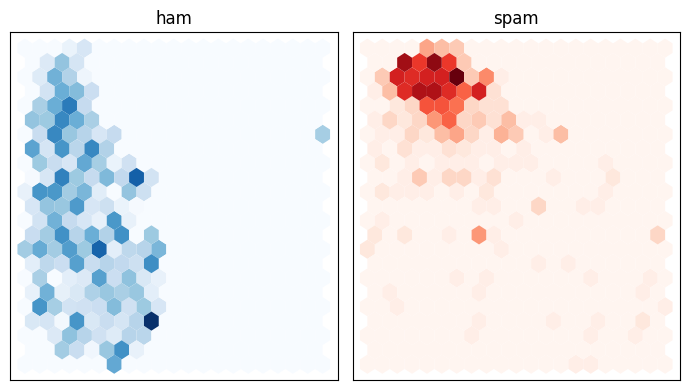

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7,4))
axes = axes.flatten()
cmaps = ["Blues", "Reds"]
labels = ["ham","spam"]
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout()
plt.show()

From the plot we can see that the spam message have some natural structure which is different from the ham messages. Neverthesless, we see that there is some overlap.

### 2.4.2. Visualising last hidden states

Now we do the same as before but after the input_ids have been processed inside the transformers model. Our expectation is that the segmentation will be even bigger.

In [ ]:
X_hidden = dataset_hidden['train']['hidden_state']

In [ ]:
X_hidden.shape

torch.Size([4459, 768])

In [ ]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_hidden)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
df_emb["label"] = y_train.values
df_emb.head()

,X,Y,label
0,11.283801,6.371366,0
1,3.358445,0.036304,1
2,10.982726,9.030395,0
3,8.951480,8.621796,0
4,12.319787,3.001784,0


The output df_emb contains the 768 feature vectors projected to a 2 dimensional space. Let's see how this looks like.

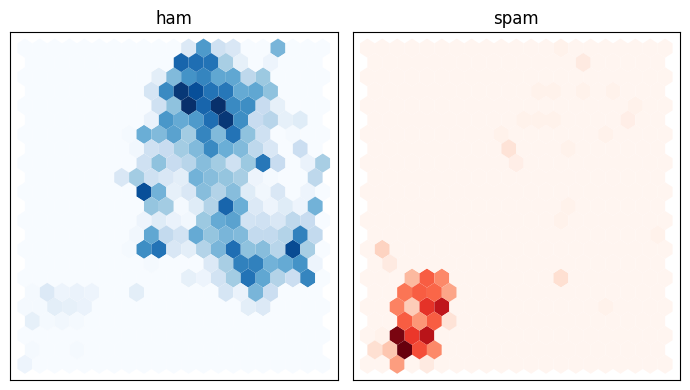

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7,4))
axes = axes.flatten()
cmaps = ["Blues", "Reds"]
labels = ["ham","spam"]
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout()
plt.show()

There is a clear trend of how the pretained DistilBert matches spam and ham SMS messages and we also see that the distinction is much bigger than from the simple tokenized dataset.

Since the trends is so clear, we can actually evalate our model on a couple on the previously defined sample spam and ham messages from above. Let's see whether our model can naturally distinguish such messages.

In [ ]:
model_bert.eval() # ensures that dropout layers are deactivated
spam_sample_tokenized = tokenizer_bert(spam_sms_list, padding= True, return_tensors = 'pt').to(device)
non_spam_sample_tokenized = tokenizer_bert(non_spam_sms_list, padding= True, return_tensors = 'pt').to(device)
with torch.no_grad():
    inputs_spam = {key : spam_sample_tokenized[key] for key in tokenizer_bert.model_input_names}
    inputs_ham = {key : non_spam_sample_tokenized[key] for key in tokenizer_bert.model_input_names}
    y_pred_spam = torch.argmax(model_bert(**inputs_spam).logits, axis = -1).cpu().numpy()
    y_pred_ham = torch.argmax(model_bert(**inputs_ham).logits, axis = -1).cpu().numpy()

In [ ]:
print(y_pred_spam)
print(y_pred_ham)

[0 1 0 0 1 0 1 0]
[1 0 1 0 0 0 0 0]


The results, for this test set, are not very good. It should be mentioned that in the visualization above we simply visualized the last hidden state. But in predictive tests, the classification head role plays are part as well. So it seems like the classification head is destroying our predictions. Hopefully, our model will be much better after training!

# 2.5 Fine tuning the model

Having tokenized the whole dataset, we are in a position to fine tune our model. Our model already has the classification head attached to it. Thus, the only thing left we need is a dataloader and via the trainer API from huggingface we will conveniently train our model. First, we need to define a metric, which in our case is going to be accuracy and the f1-score.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
%pip uninstall wandb
import os
os.environ["WANDB_MODE"] = "disabled" # we do that as otherwise the trainer wants to push the model to the hugging face hub, which we don't want

Found existing installation: wandb 0.19.5
Uninstalling wandb-0.19.5:
  Would remove:
    /usr/local/bin/wandb
    /usr/local/bin/wb
    /usr/local/lib/python3.11/dist-packages/package_readme.md
    /usr/local/lib/python3.11/dist-packages/wandb-0.19.5.dist-info/*
    /usr/local/lib/python3.11/dist-packages/wandb/*
Proceed (Y/n)? y
  Successfully uninstalled wandb-0.19.5


Define the trainer arguments as input for our trainer.

In [ ]:
# define path so save model after trainig
os.chdir('/content/drive/MyDrive/_BOOK_Natural Langue Processing with Transformers/Chapter 2 - Text Classification/SMS')

In [ ]:
os.getcwd()

'/content/drive/MyDrive/_BOOK_Natural Langue Processing with Transformers/Chapter 2 - Text Classification/SMS'

We will train the model for 3 epochs.

In [ ]:
from transformers import Trainer, TrainingArguments
batch_size = 64
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = "distilbert-base-uncased-finetuned-sms"
training_args = TrainingArguments(output_dir=model_name,
                                 num_train_epochs=3,
                                 learning_rate=2e-5,
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 weight_decay=0.01,
                                 eval_strategy="epoch",
                                 report_to=None,
                                 disable_tqdm=False,
                                 logging_steps=logging_steps,
                                 push_to_hub=False,
                                 log_level="error")

In [ ]:
from transformers import Trainer
trainer = Trainer(model=model_bert, args=training_args,
                 compute_metrics=compute_metrics,
                 train_dataset=dataset_encoded["train"],
                 eval_dataset=dataset_encoded["test"],
                 tokenizer=tokenizer_bert)
trainer.train()

<ipython-input-59-be2c4553e874>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model_bert, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.160800,0.046451,0.988341,0.988390
2,0.032200,0.038246,0.991031,0.991006
3,0.017200,0.038169,0.991031,0.991006


TrainOutput(global_step=210, training_loss=0.0697674355336598, metrics={'train_runtime': 707.1928, 'train_samples_per_second': 18.916, 'train_steps_per_second': 0.297, 'total_flos': 1772016391821312.0, 'train_loss': 0.0697674355336598, 'epoch': 3.0})

The mode is significantly better than our Naive Bayes model. Comparing the f1 score it achieves over 99%, while the Naive Bayes model approach was about 94%.

In [ ]:
trainer.save_model() # save model in the output_dir
# load model
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_bert = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sms")
tokenizer_bert = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sms")

In [ ]:
model_bert.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


### 2.5.1 Evaluating the model

As a first test, let us again check the samples from above whether they are spam or ham. We will use the inputs_spam and inputs_ham dictionaries from above as well.

In [ ]:
model_bert.eval()
with torch.no_grad():
    print(torch.argmax(model_bert(**inputs_spam).logits, axis = -1 )) # predict spams
    print(torch.argmax(model_bert(**inputs_ham).logits, axis = -1 ))  # predict hams

tensor([1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')


The results are certainly much better than before but the model still does not fully recognise spam and hams. But to be fair, some of those ham messages are hard to differentiate from spam messages and vice versa.

Let us now put our attention to the test dataset and check where the model went wrong, i.e., investigate the fp and fn.

We store the data in a dataloader and evaluate the model's performance in batches.

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
inputs = dataset_encoded['test']['input_ids'].to(device)
attention_masks = dataset_encoded['test']['attention_mask'].to(device)
batch_size = 16
dataset = TensorDataset(inputs, attention_masks)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model_bert.eval()
y_preds = []
with torch.no_grad():
    for batch in data_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        preds_output = model_bert(input_ids=input_ids,attention_mask = attention_mask).logits
        y_preds.append(np.argmax(preds_output.squeeze().cpu().numpy(), axis = -1)) # stores the results as list of arrays

In [ ]:
y_pred = np.concatenate(y_preds)
confusion_matrix(y_pred,y_test)

array([[962,   6],
       [  4, 143]])

Check the false positive sms

In [ ]:
for i, sms in enumerate(X_test[(y_pred == 1) & (y_test == 0)]):
    print("%2d) %-s" % (i+1, sms.strip()))

 1) MY NO. IN LUTON 0125698789 RING ME IF UR AROUND! H*
 2) Somebody set up a website where you can play hold em using eve online spacebucks
 3) We are pleased to inform that your application for Airtel Broadband is processed successfully. Your installation will happen within 3 days.
 4) staff.science.nus.edu.sg/~phyhcmk/teaching/pc1323


And the false negative ones

In [ ]:
for i, sms in enumerate(X_test[(y_pred == 0) & (y_test == 1)]):
    print("%2d) %-s" % (i+1, sms.strip()))

 1) Hi ya babe x u 4goten bout me?' scammers getting smart..Though this is a regular vodafone no, if you respond you get further prem rate msg/subscription. Other nos used also. Beware!
 2) ROMCAPspam Everyone around should be responding well to your presence since you are so warm and outgoing. You are bringing in a real breath of sunshine.
 3) Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?
 4) RCT' THNQ Adrian for U text. Rgds Vatian
 5) For sale - arsenal dartboard. Good condition but no doubles or trebles!
 6) 0A$NETWORKS allow companies to bill for SMS, so they are responsible for their "suppliers", just as a shop has to give a guarantee on what they sell. B. G.


Honestly, some of the are very hard to judge. There always exists the chance of humand missclassification. For example, the sms with the old ladies and tattoos. For me that does not sound like spam but more of a showerthought. Only the first example of the false negative one is clearly wrong by the model since the first word ROMCAPspam also implies the spam.

## 3.0 Classifying sms with GPT2

Binary classification using GPT2 is a rather uncommen approach as it is a generate transformer model. We wil try it nonetheless! The idea is to modify the training data and let GPT2 generate the classification.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load the distilled version of GPT-2
tokenizer_gpt2 = AutoTokenizer.from_pretrained("distilgpt2")
model_gpt2 = AutoModelForCausalLM.from_pretrained("distilgpt2")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gpt2.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
text = 'The dog Joey was jumping over the '
text_tokens = tokenizer_gpt2(text, return_tensors = 'pt').to(device)
output = model_gpt2.generate(**text_tokens, max_length = 50, pad_token_id = tokenizer_gpt2.eos_token_id, do_sample = True, top_p = 0.9)
print(tokenizer_gpt2.decode(output.squeeze()))

The dog Joey was jumping over the ick-bump from behind her, to where she was just beginning to jump the head of a dog, and she fell to the ground. She went back and ran, but nothing stopped her. She was


Our model works. Now we add the ' This sms is: ' part to our training and test data.

In [ ]:
def preprocess(example):
    input_text = example["sms"]
    label_text = "ham" if example["label"] == 0 else "spam"
    combined_text = input_text + " This SMS is: "  # Combine input and output
    tokenized_input = tokenizer_gpt2(combined_text, truncation=True)
    tokenized_label = tokenizer_gpt2(label_text, truncation=True)

    # for training we the tokenized sms and labels must be the same length
    labels_input_ids = tokenized_label["input_ids"]
    labels = tokenized_input["input_ids"][:]  # copy input_ids
    labels[:len(labels_input_ids)] = labels_input_ids
    labels[len(labels_input_ids):] = np.repeat([-100],len(labels)-len(labels_input_ids)) # Mask other positions

    return {"input_ids": tokenized_input["input_ids"], "attention_mask": tokenized_input["attention_mask"], 'labels' : labels}

The preprocess function is doing 2 things:

    1. add 'This SMS is: ' to SMS
    2. pad labels to the same length as input_ids by [-100] tokens. Such tokens are ignored in the loss function

In [ ]:
tokenizer_gpt2.convert_ids_to_tokens(tokenizer_gpt2('spam')['input_ids'])

['sp', 'am']

In [ ]:
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token
ds_3 = ds.map(preprocess)

Map:   0%|          | 0/4459 [00:00<?, ? examples/s]

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

In [ ]:
print(ds_3['train']['input_ids'][0])
print(ds_3['train']['labels'][0])
print(len(ds_3['train']['input_ids'][0]) == len(ds_3['train']['labels'][0]))

tensor([18690,  1312,   716,   319,   262,   835,   284,  1363, 23105, 23105,
          198,   770, 29287,   318,    25,   220])
tensor([2763, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100])
True


In [ ]:
dataset_encoded = ds_3

In [ ]:
dataset_encoded.set_format('torch', columns = ['input_ids', 'attention_mask','labels']) # set tensors as input for our model. We don't need the label column anymore for tacher forcing

Let us vanilla check whether GPT2 can already identify spam from non-spam.

In [ ]:
inputs = {k:v.to(device) for k,v in dataset_encoded['test'][:1].items() if k in tokenizer_gpt2.model_input_names}
output = model_gpt2.generate(**inputs, max_new_tokens = 1)
tokenizer_gpt2.decode(output[0], skip_special_tokens=True)

'No message..no responce..what happend?\n This SMS is: ********'

Evidently, this does not work yet. We need to train our model.

### 3.1. Train GPT2 model

In this chapter we will train our model.

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
%pip uninstall wandb
import os
os.environ["WANDB_MODE"] = "disabled" # we do that as otherwise the trainer wants to push the model to the hugging face hub, which we don't want

In [ ]:
batch_size = 1
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = "gpt2-finetuned-sms"
training_args = TrainingArguments(output_dir=model_name,
                                  gradient_accumulation_steps=4,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_steps=500,
                                  report_to=None,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [ ]:
from transformers import Trainer
trainer = Trainer(model=model_gpt2, args=training_args,
                  train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["test"],
                  tokenizer=tokenizer_gpt2)
trainer.train()

<ipython-input-89-7eaffbb24b44>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model_gpt2, args=training_args,


Step,Training Loss


TrainOutput(global_step=3342, training_loss=1285892170.7624178, metrics={'train_runtime': 581.0873, 'train_samples_per_second': 23.021, 'train_steps_per_second': 5.751, 'total_flos': 97678032961536.0, 'train_loss': 1285892170.7624178, 'epoch': 2.9975330791657324})

Looking at the values in the loss, something went completely wrong. Let us check the output

The rest of this chapter's code is similar to DistilBert. Save the model, load it again and test it on the test set.

In [ ]:
trainer.save_model() # save model in the output_dir
# load model
from transformers import AutoModelForCausalLM, AutoTokenizer
tokenizer_gpt2 = AutoTokenizer.from_pretrained("gpt2-finetuned-sms")
model_gpt2 = AutoModelForCausalLM.from_pretrained("gpt2-finetuned-sms")

In [ ]:
model_gpt2.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
from torch.utils.data import DataLoader

# Define a DataLoader
test_dataloader = DataLoader(dataset_encoded['test'], batch_size=1, shuffle=False)

# Get a batch
for i, batch in enumerate(test_dataloader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    output = model_gpt2.generate(input_ids = input_ids, attention_mask = attention_mask, max_new_tokens = 1)
    output = tokenizer_gpt2.decode(output[0]).strip()
    print(output)
    if i == 10:
        break  # Just to check one batch

No message..no responce..what happend?
 This SMS is: am
At WHAT TIME should i come tomorrow
 This SMS is: am
Come to my home for one last time i wont do anything. Trust me.
 This SMS is: am
Get ur 1st RINGTONE FREE NOW! Reply to this msg with TONE. Gr8 TOP 20 tones to your phone every week just £1.50 per wk 2 opt out send STOP 08452810071 16
 This SMS is: am
See you there! 
 This SMS is: am
Great. So should i send you my account number.
 This SMS is: am
WIN: We have a winner! Mr. T. Foley won an iPod! More exciting prizes soon, so keep an eye on ur mobile or visit www.win-82050.co.uk
 This SMS is: am
Do we have any spare power supplies
 This SMS is: am
Ok good then i later come find ü... C lucky i told ü to go earlier... Later pple take finish ü no more again...
 This SMS is: am
Ok try to do week end course in coimbatore.
 This SMS is: am
Ard 530 like dat lor. We juz meet in mrt station then ü dun haf to come out.
 This SMS is: am


We somehow trained our model to simpl always output 'am'. If we generate more tokens, the output is just a concatination of ams

In [ ]:
for i, batch in enumerate(test_dataloader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    output = model_gpt2.generate(input_ids = input_ids, attention_mask = attention_mask, max_new_tokens = 10)
    output = tokenizer_gpt2.decode(output[0]).strip()
    print(output)
    if i == 10:
        break  # Just to check one batch

No message..no responce..what happend?
 This SMS is: amamamamamamamamamam
At WHAT TIME should i come tomorrow
 This SMS is: amamamamamamamamamam
Come to my home for one last time i wont do anything. Trust me.
 This SMS is: amamamamamamamamamam
Get ur 1st RINGTONE FREE NOW! Reply to this msg with TONE. Gr8 TOP 20 tones to your phone every week just £1.50 per wk 2 opt out send STOP 08452810071 16
 This SMS is: amamamamamamamamamam
See you there! 
 This SMS is: amamamamamamamamamam
Great. So should i send you my account number.
 This SMS is: amamamamamamamamamam
WIN: We have a winner! Mr. T. Foley won an iPod! More exciting prizes soon, so keep an eye on ur mobile or visit www.win-82050.co.uk
 This SMS is: amamamamamamamamamam
Do we have any spare power supplies
 This SMS is: amamamamamamamamamam
Ok good then i later come find ü... C lucky i told ü to go earlier... Later pple take finish ü no more again...
 This SMS is: amamamamamamamamamam
Ok try to do week end course in coimbatore.
 Thi

We will look into what went wrong in another workbook.